# Architectural Tradeoff Analysis (PCA)

In [223]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from paretoset import paretoset
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize_scalar
from adjustText import adjust_text

In [94]:
# Read simulation data
# Full = with SQS
df_full = pd.DataFrame(
    pd.read_csv(r"C:\Users\KarlO\architectural-tradeoff-analysis\Simulation data\official_runs\full_1.csv"))
# Simple = without SQS
df_simple = pd.DataFrame(
    pd.read_csv(r"C:\Users\KarlO\architectural-tradeoff-analysis\Simulation data\official_runs\simple_1.csv"))

df = pd.concat([df_full, df_simple])

In [95]:
df_scatter = df.copy()
df_scatter["e_SQS"] = df_scatter["e_SQS"].astype(str)
fig = px.scatter_matrix(df_scatter,
    dimensions=['queue_size', 'timeout','parallel_instances','lambda_chunk_size'],
    color="e_SQS",
    title = "Scatter matrix of parameters")
fig.update_traces(diagonal_visible=False)

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)
        
fig.show()

In [206]:
ct_df = df[['time', 'cost']]

ct_nonoptimal = ct_df.copy()
df_nonoptimal = df.copy()

optimal = []

for i in range(600):
    mask = paretoset(ct_nonoptimal, sense=["min", "min"])
    masklist = mask.tolist()
    indices = [index for (index, item) in enumerate(masklist) if item == True]
    ct_nonoptimal.drop(ct_nonoptimal.index[indices], inplace=True)
    df_nonoptimal.drop(df_nonoptimal.index[indices], inplace=True)
    
df_pareto= pd.concat([df, df_nonoptimal])
df_pareto = df_pareto.drop_duplicates(keep=False)
# Filter outliers
df_pareto = df_pareto[df_pareto.time < 80]

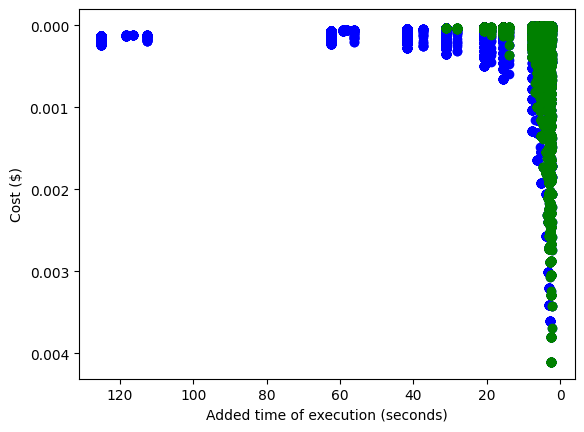

In [207]:
plt.scatter(df['time'], df['cost'], color='b')
#plt.scatter(df_filtered_nonoptimal['time'], df_filtered_nonoptimal['cost'], color='r')
plt.scatter(df_pareto['time'], df_pareto['cost'], color='g')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('Added time of execution (seconds)')
plt.ylabel('Cost ($)')
plt.show()

In [217]:
# Scale dataframe (gets turned into ndarray which gets retransformed back to dataframe)
scaled_ndarr = preprocessing.scale(df_pareto)
scaled_df = pd.DataFrame(scaled_ndarr, columns = df_pareto.columns)

# Create correlation matrix
corr_opt = scaled_df.corr()
corr_opt = corr_opt.fillna(0)

# Same for full matrix (without pareto)
scaled_ndarr_full = preprocessing.scale(df_pareto)
scaled_df_full = pd.DataFrame(scaled_ndarr_full, columns = df_pareto.columns)

corr_full = scaled_df_full.corr()
corr_full = corr_full.fillna(0)

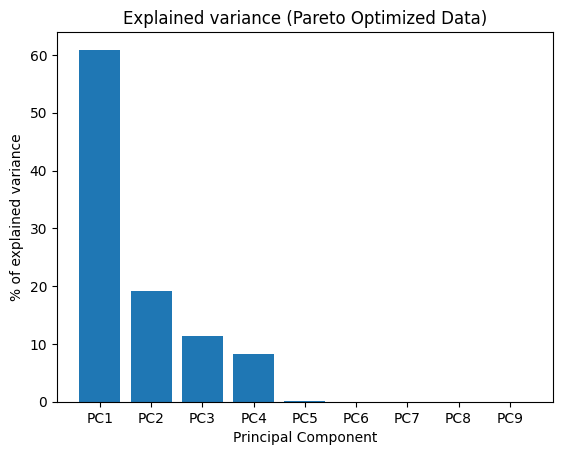

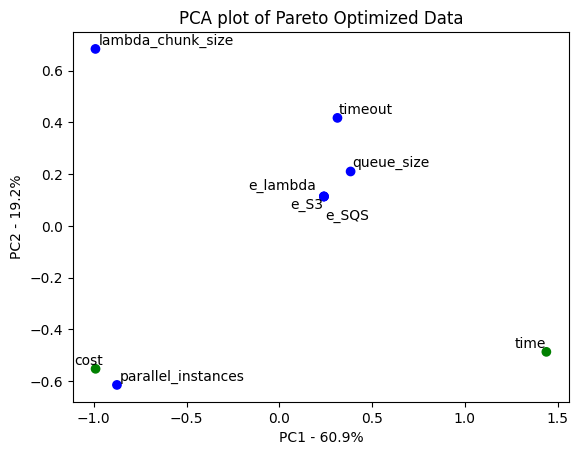

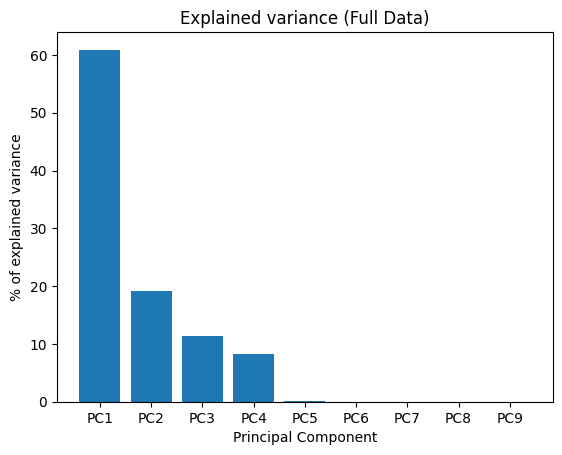

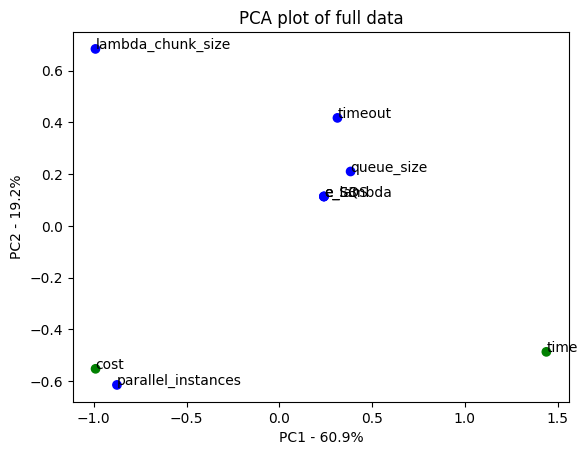

In [238]:
# assign categories
categories = np.array([0, 0, 0, 0, 0, 0, 0, 1, 1])
 
# use colormap
colormap = np.array(['b', 'g'])

# Pareto optimised
corr_opt_arr = corr_opt.to_numpy()
pca_opt = PCA()
pca_opt.fit(corr_opt_arr)
pca_opt_data = pca_opt.transform(corr_opt_arr)
# Calculate percentage of variation that each PC (principal component) accounts for
per_var = np.round(pca_opt.explained_variance_ratio_*100, decimals=1)
# Create labels
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
# Plot scree plot
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('% of explained variance')
plt.xlabel('Principal Component')
plt.title('Explained variance (Pareto Optimized Data)')
plt.show()

pca_opt_df = pd.DataFrame(pca_opt_data, index=corr_opt.columns, columns=labels)

plt.scatter(pca_opt_df.PC1, pca_opt_df.PC2, c=colormap[categories])
plt.title('PCA plot of Pareto Optimized Data')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

texts = [plt.text(pca_opt_df.PC1[i], pca_opt_df.PC2[i], pca_full_df.PC1.keys()[i]) for i in range(len(pca_opt_df.PC2))]
adjust_text(texts)

plt.show()

# Full data
corr_full_arr = corr_full.to_numpy()
pca_full = PCA()
pca_full.fit(corr_full_arr)
pca_full_data = pca_full.transform(corr_opt_arr)
# Calculate percentage of variation that each PC (principal component) accounts for
per_var = np.round(pca_full.explained_variance_ratio_*100, decimals=1)
# Create labels
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
# Plot scree plot
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('% of explained variance')
plt.xlabel('Principal Component')
plt.title('Explained variance (Full Data)')
plt.show()

pca_full_df = pd.DataFrame(pca_full_data, index=corr_full.columns, columns=labels)

plt.scatter(pca_full_df.PC1, pca_full_df.PC2,  c=colormap[categories])
plt.title('PCA plot of full data')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

texts = [plt.text(pca_opt_df.PC1[i], pca_opt_df.PC2[i], pca_full_df.PC1.keys()[i]) for i in range(len(pca_opt_df.PC2))]
adjust_text(texts)
                 
plt.show()

In [237]:
print(pca_full_df.PC1.keys())
print(pca_full_df.PC2)

Index(['e_SQS', 'queue_size', 'timeout', 'e_S3', 'e_lambda',
       'parallel_instances', 'lambda_chunk_size', 'time', 'cost'],
      dtype='object')
e_SQS                 0.113735
queue_size            0.210319
timeout               0.417313
e_S3                  0.113735
e_lambda              0.113735
parallel_instances   -0.614188
lambda_chunk_size     0.683731
time                 -0.486441
cost                 -0.551939
Name: PC2, dtype: float64
